<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1c_regresion_lineal_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regresión lineal simple

#### <div style="text-align: right">Berenice Montalvo Lezama</div>

[PyTorch](https://pytorch.org/) es una librería de aprendizaje de máquina de código abierto cuyo propósito es reducir la brecha entre prototipos y producción. Provee una interfaz similar a NumPy para manipulación de tensores, así como implementaciones de alto nivel de muchas de las utilidades necesarias para la construcción de redes neuronales profundas.

Para comenzar a familiarizarnos con PyTorch implementaremos un modelo de regresión lineal simple sobre un conjunto de datos de calificaciones, lo que deseamos predecir es que calificación tendrá el alumno en un examen. El conjunto de datos posee dos atributos entrada: la calificación que obtuvo en un examen previo y el número de horas que estudio el alumno para presentar el examen. En este ejemplo nos enfocaremos en realizar regresion lineal univariada, por lo tanto, consideraremos únicamente un atributo de entrada, el número de horas de estudio.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

# para reproducibilidad
torch.manual_seed(2019);

## Carga de datos

In [2]:
datos = np.loadtxt('../data/califs/califs.csv', dtype=np.float32, delimiter=',')
X, y = datos[:, [1]], datos[:, -1]

Graficamos los datos tener una idea más clara de como se encuentran distribuidos.

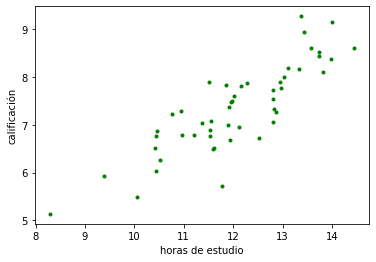

In [3]:
plt.plot(X.ravel(), y, '.', color='green')
plt.xlabel('horas de estudio')
plt.ylabel('calificación');

PyTorch incluye muchas utilidades para facilitar la carga y procesamiento de datos. Las principales son `Dataset` y `DataLoader` incluidas en el módulo `torch.data.utils`. 

`Dataset` es una clase que nos permite definir el proceso de carga que deseemos implementando una clase que herede de ella y definiendo los métodos `__len__` (longitud del dataset) y `__getitem__` (qué debe regresar el dataset cuando se indexa).

Un `DataLoader` construye un generador a partir de un `Dataset` que permite obtener sus elementos en batches con la posibilidad de ser permutados y, opcionalmente, cargarlos en paralelo.

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class PrimerDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Nuestro primer Dataset recibirá una matriz X y un vector y. 

In [6]:
ds = PrimerDataset(X, y)

Su longitud estará dada por el número de muestras (longitud del vector y).

In [7]:
len(ds)

50

Al indexarlo regresará el renglón correspondiente de la matrix X y del vector y.

In [8]:
ds[1]

(array([9.389], dtype=float32), 5.931)

Una vez que tenemos nuestro dataset definido, podemos crear un DataLoader.

In [9]:
batch_size = 8
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [10]:
# iteramos sobre los lotes
for x, y_true in dl:
    # imprimimoos las dimensiones del atributo de entrada X y la salida Y
    print(x.shape, y_true.shape)
    # imprimimos el primer elemento de cada lote
    print(x[0].numpy(), y_true[0].numpy())

torch.Size([8, 1]) torch.Size([8])
[12.865] 7.258
torch.Size([8, 1]) torch.Size([8])
[11.915] 7.368
torch.Size([8, 1]) torch.Size([8])
[12.943] 7.896
torch.Size([8, 1]) torch.Size([8])
[13.577] 8.612
torch.Size([8, 1]) torch.Size([8])
[13.821] 8.106
torch.Size([8, 1]) torch.Size([8])
[12.164] 7.814
torch.Size([2, 1]) torch.Size([2])
[12.111] 6.954


### Quiz 1

¿ Cuáles serían las dimensiones si consideraramos los dos atributos de entrada?

## Definición del modelo


Un módulo de PyTorch es una clase que hereda de `nn.Module`. Al inicializar la clase se debe inicializar la clase padre usando `super().__init__()` y también definir todas las operaciones que involucren parámetros a ser optimizados.

Los módulos realizan las operaciones definidas en el método `forward`.

In [11]:
class RegLin(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc(x)
        return x.squeeze() # Para hacer vector

### Quiz 2

¿Cómo podríamos dibujar la regresión lineal como una red neuronal?

## Definición de la función perdida

Se define el error cuadrático medio como función de pérdida.

![alt text](../figs/ecm.png)

In [12]:
loss_fn = nn.MSELoss()

Inicializamos el modelo

In [13]:
model = RegLin()

Revisamos sus parámetros, los cuales son la pendiente y la ordenada.

In [14]:
print(*list(model.parameters()), sep='\n\n')

Parameter containing:
tensor([[0.9456]], requires_grad=True)

Parameter containing:
tensor([-0.5977], requires_grad=True)


Se define el gradiente descendente estocástico como optimizador, pasandole los parámetros del modelo (los cuales son los parámetros que tengan los atributos definidos al inicializar la clase) y se le asigna una tasa de aprendizaje.

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Entrenamiento

El entrenamiento de un paso del modelo se ilustra con la siguiente figura:
![alt text](../figs/model_graph.png "Title")

Realizamos el entrenamiento de nuestro modelo durante dos epocas.

In [16]:
epochs = 2
loss_history = []
step = 0

for _ in range(epochs):
    
    for x, y_true in dl:
        optimizer.zero_grad() # Hacemos ceros los gradientes
        y_pred = model(x)
        loss = loss_fn(y_true, y_pred)
        loss.backward() # Calculamos los gradientes
        optimizer.step() # Se actualizan los parámetros

        print(f'Step: {step:>2} Loss: {loss.item():.4f}')
        loss_history.append(loss.item())
        
        step += 1

Step:  0 Loss: 12.1553
Step:  1 Loss: 6.8947
Step:  2 Loss: 2.6196
Step:  3 Loss: 1.4652
Step:  4 Loss: 0.6932
Step:  5 Loss: 1.3481
Step:  6 Loss: 0.2791
Step:  7 Loss: 0.1117
Step:  8 Loss: 0.3150
Step:  9 Loss: 0.2247
Step: 10 Loss: 0.1669
Step: 11 Loss: 0.2023
Step: 12 Loss: 0.5598
Step: 13 Loss: 0.0558


Graficamos la pérdida para ver el comportamiento durante el entrenamiento.

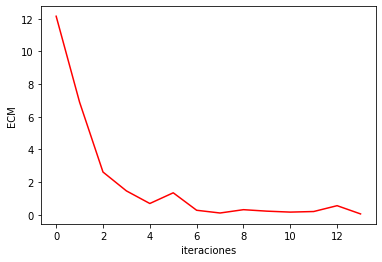

In [17]:
plt.plot(loss_history, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

## Inferencia

Graficamos nuestro modelo.

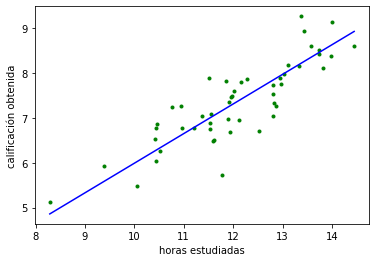

In [18]:
with torch.no_grad(): # no necesitamos que calcule gradientes
    Xt = torch.from_numpy(X)
    y_pred = model(Xt).numpy()
plt.plot(X, y, '.', color='green')
plt.plot(X, y_pred, color='blue')
plt.xlabel('horas estudiadas')
plt.ylabel('calificación obtenida');